<a href="https://colab.research.google.com/github/VRB01/capstone/blob/main/Datasethandling_librispeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os
import numpy
from keras.models import Sequential
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers import Dense
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
Directory = 'gdrive/MyDrive/Capstone Data/LibriSpeech/train-clean-100'
Dataset = os.listdir(Directory)

In [ ]:
audio_list = []
speakers = []
for speaker in Dataset:
  chapters = os.listdir(Directory+'/'+speaker)
  for chapter in chapters:
    audios = os.listdir(Directory+'/'+speaker+'/'+chapter)
    for audio in audios:
      if(audio.endswith('.flac')):
        audio_list.append(Directory+'/'+speaker+'/'+chapter+'/'+audio)
        speakers.append(audio.split('-')[0])




In [ ]:
audio_list = pd.DataFrame(audio_list)
audio_list = audio_list.rename(columns={0:'file'})
#len(audio_list)
len(speakers)

28549

In [ ]:
audio_list['speaker'] = speakers
df = audio_list.sample(frac=1, random_state=42).reset_index(drop=True)
df = df[:12000]
df_train = df[:8000] #19984:
df_validation = df[8000:11000] #19984:25694
df_test = df[11000:12000] #25694:
labels = df['speaker']
Counter = 1
df

,file,speaker
0,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,6836
1,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,3168
2,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,4830
3,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8226
4,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,909
...,...,...
11995,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8580
11996,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,1040
11997,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,2136
11998,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,7794


In [ ]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(str(files.file))
    global Counter
    if(Counter%100==0):
      print(Counter)
    Counter+=1

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    #stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    #sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    #label = files.label

    return mel, mfccs

In [ ]:
startTime = datetime.now()
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)
print(datetime.now() - startTime)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
1:11:29.762584


In [ ]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label', features_label)


In [ ]:
# loading the features
features_label = np.load('features_label.npy', allow_pickle=True)

In [ ]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1]), axis=0))
# x_train = features_label[:1100]
# x_test = features_label[1100:]
# y_train = labels[:1100]
# y_test = labels[1100:]

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_train = list(x_train)
# x_train = np.asarray(x_train).astype('float32')

# #x_train = scaler.fit_transform(x_train)
# print(x_train.shape)
# x_train = x_train.reshape(1100,-1,128)
# x_test = list(x_test)
# x_test = np.asarray(x_test).astype('float32')

# #x_test = scaler.fit_transform(x_test)
# print(x_test.shape)
# x_test = x_test.reshape(100,-1,128)

(1100, 128)
(100, 128)


In [ ]:
# y_train = np.asarray(y_train).astype('float32')
# #y_train = scaler.fit_transform([y_train])
# y_test = np.asarray(y_test).astype('float32')
# #y_test = scaler.fit_transform([y_test])

In [ ]:
# model = Sequential()
# model.add(LSTM(100, return_sequences=True, input_shape=(1200,128)))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model)

In [ ]:
# h = model.fit(x_train, y_train, epochs=60, batch_size=32, validation_data=(x_test,y_test))

In [ ]:
# import matplotlib.pyplot as plt
# xAxis = []
# for i in range(1,len(h.history['loss'])+1):
#   xAxis.append(i)
# #norm = [(0-float(i))/sum(h.history['loss']) for i in h.history['loss']]
# #norm1 = [(float(i)-min(h.history['loss']))/(max(h.history['loss'])-min(h.history['loss'])) for i in h.history['loss']]
# plt.plot(xAxis,h.history['loss'])
# plt.title('title name')
# plt.xlabel('xAxis name')
# plt.ylabel('yAxis name')
# plt.show()
# y_pred = model.predict(x_test)

# #y_pred = scaler.inverse_transform(pred)
# #y_test = scaler.inverse_transform([y_test])
# # from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [ ]:
# print(features_label)
# train_features = np.array(features_label[:800])
# val_features = [features_label[800:1100]]
# test_features = [features_label[1100:]]
# features = []
# features.append(np.concatenate(features_label, axis=0))
# print(features)
# #print(train_features)

In [ ]:
X = np.array(features)
y = np.array(labels)
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))
X.shape

(12000, 168)

In [ ]:
X_train = X[:8000]
y_train = y[:8000]

X_val = X[8000:11000]
y_val = y[8000:11000]

X_test = X[11000:]
y_test = y[11000:]


In [ ]:
# features_label[800:1100]

In [ ]:
# X_val.shape

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [ ]:
# Build a simple dense model with early stopping with softmax for categorical classification
# We have 115 classes 

model = Sequential()
model.add(Dense(168, input_shape=(168,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    
model.add(Dense(251, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 100 because we did not want to use early stop
# I leave the early stop regularization code in case anyone wants to use it

history = model.fit(X_train, y_train, batch_size=64, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/100
125/125 [==============================] - 2s 7ms/step - loss: 5.3998 - accuracy: 0.0217 - val_loss: 3.8342 - val_accuracy: 0.2667
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 3.8468 - accuracy: 0.1517 - val_loss: 2.0203 - val_accuracy: 0.6540
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 2.6783 - accuracy: 0.3298 - val_loss: 1.2083 - val_accuracy: 0.7897
Epoch 4/100
125/125 [==============================] - 1s 4ms/step - loss: 1.9356 - accuracy: 0.4866 - val_loss: 0.7833 - val_accuracy: 0.8690
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 1.5656 - accuracy: 0.5649 - val_loss: 0.5847 - val_accuracy: 0.8933
Epoch 6/100
125/125 [==============================] - 1s 4ms/step - loss: 1.3152 - accuracy: 0.6274 - val_loss: 0.4564 - val_accuracy: 0.9153
Epoch 7/100
125/125 [==============================] - 1s 5ms/step - loss: 1.0778 - accuracy: 0.6894 - val_loss: 0.3692 - val_accuracy: 0.9273

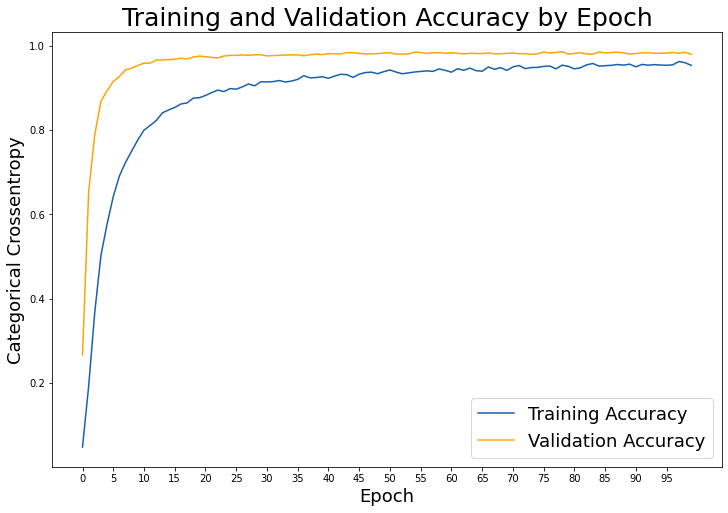

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
import matplotlib.pyplot as plt
# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [ ]:
# We get our predictions from the test data
preds = model.predict_classes(X_test)
# We transform back our predictions to the speakers ids
preds = lb.inverse_transform(preds)
# We slice our dataframe to our test dataframe
df_test = df[11000:]
# We create a new column called preds and set it equal to our predictions
df_test['preds'] = preds
# Checking how our test dataframe looks like now with our predictions
df_test


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,file,speaker,preds
11000,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,5789,5789
11001,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8629,201
11002,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,196,196
11003,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,2289,2289
11004,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8609,8609
...,...,...,...
11995,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8580,8580
11996,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,1040,1040
11997,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,2136,2136
11998,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,7794,7794


In [ ]:
# Checking how many speakers we got wrong
df_test[df_test['speaker'] != df_test['preds']]


,file,speaker,preds
11001,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8629,201
11028,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,2893,8838
11073,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,1502,7800
11142,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,3242,6454
11166,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,8324,7278
11378,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,4297,1867
11448,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,2391,5163
11460,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,1034,198
11482,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,6836,254
11507,gdrive/MyDrive/Capstone Data/LibriSpeech/train...,6415,6454


In [ ]:
# Checking our model accuracy
1-round(len(df_test[df_test['speaker'] != df_test['preds']])/len(df_test),3)

0.982